In [1]:
import pandas as pd
import sys
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
datadir = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/"
path_to_file5sec = os.path.join(datadir, "__016563_2014-08-08 12-02-19.bin_day1.csv")

In [3]:
filenames = os.listdir(datadir)
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames if os.path.isfile(os.path.join(datadir,fn))]
print(len(datasets))

21


In [4]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 
    datasets[i]['Activity'] = [str(a) for a in datasets[i]['Activity']]

In [5]:
subsets = []
for j, dataset in enumerate(datasets):
    invalids = [1] + list(dataset['invalid']) + [1]
    starts = [i for i in range(1, len(invalids)-1) if invalids[i-1] == 1 and invalids[i] == 0]
    ends = [i for i in range(1, len(invalids)) if invalids[i-1] == 0 and invalids[i] == 1]
    for s, e in zip(starts, ends):
        #Some minimum length
        if e-s > 300:
            subsets.append(dataset[s:e])
print(len(subsets))

23


In [6]:
for i in range(len(datasets)):
    print sum(datasets[i]['invalid'] == 1)

0
0
720
0
10800
0
0
1980
0
0
0
4140
3960
4500
4679
0
0
0
0
5400
3779


In [7]:
all_acceleration = np.array([s for d in datasets for s in list(np.array(d['acceleration']))])
print all_acceleration.shape

(362872,)


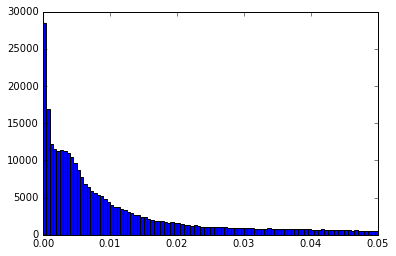

In [8]:
plt.hist(all_acceleration[all_acceleration<0.05], bins=100)
plt.xlim(0, 0.05)
plt.show()

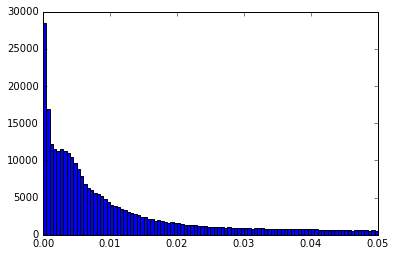

In [9]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(log_acceleration[log_acceleration<0.05], bins=100)
#plt.xlim(0, 0.05)
#plt.ylim(0,2000)
plt.show()

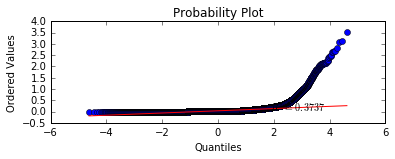

In [10]:
from scipy import stats
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(all_acceleration, dist=stats.norm, plot=ax1)
plt.show()

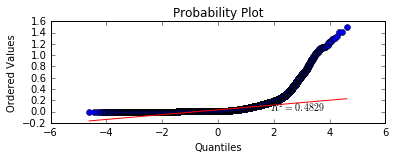

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(log_acceleration, dist=stats.norm, plot=ax1)
plt.show()

In [12]:
vals = np.sqrt(all_acceleration)
df, loc, scale = stats.chi2.fit(vals)
print(df, loc, scale)

(1.8730618744007486, -3.1466131349118666e-29, 0.071932924321726655)


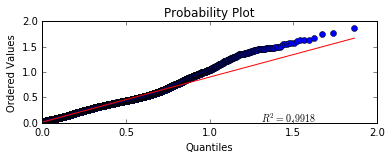

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
stats.probplot(vals, dist=stats.chi2, sparams=(df, loc, scale), plot=ax1)
plt.show()

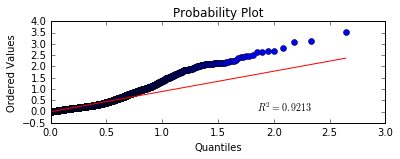

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(all_acceleration)
stats.probplot(all_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

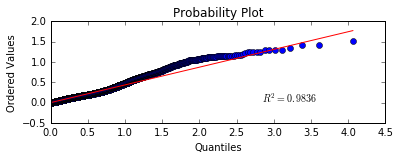

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
shape, loc, scale = stats.weibull_min.fit(log_acceleration)
stats.probplot(log_acceleration, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=ax1)
plt.show()

## Box-Cox

In [ ]:
bc_acceleration, bc_lmbda = stats.boxcox(all_acceleration+1)

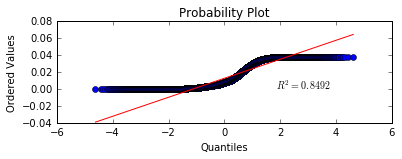

In [29]:
fig = plt.figure()
ax2 = fig.add_subplot(211)
stats.probplot(bc_acceleration, dist=stats.norm, plot=ax2)
plt.show()

In [25]:
bc_lmbda

-26.168144345203963

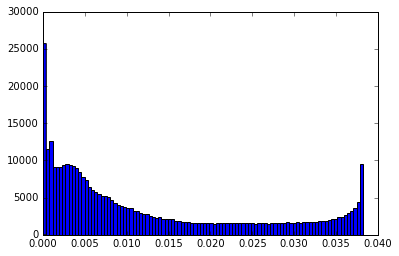

In [30]:
log_acceleration =  np.log(all_acceleration+1)
plt.hist(bc_acceleration, bins=100)
plt.show()